In [1]:
!pip install roboflow
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Get Dataset

In [5]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="ftHhmXmYoorcuab83x0O")
project = rf.workspace('desmondwong').project("pickleball-vision-pabli")
version = project.version(1)
dataset = version.download("yolov11")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
loading Roboflow workspace...
loading Roboflow project...


## Use Google Colab to run this with GPU

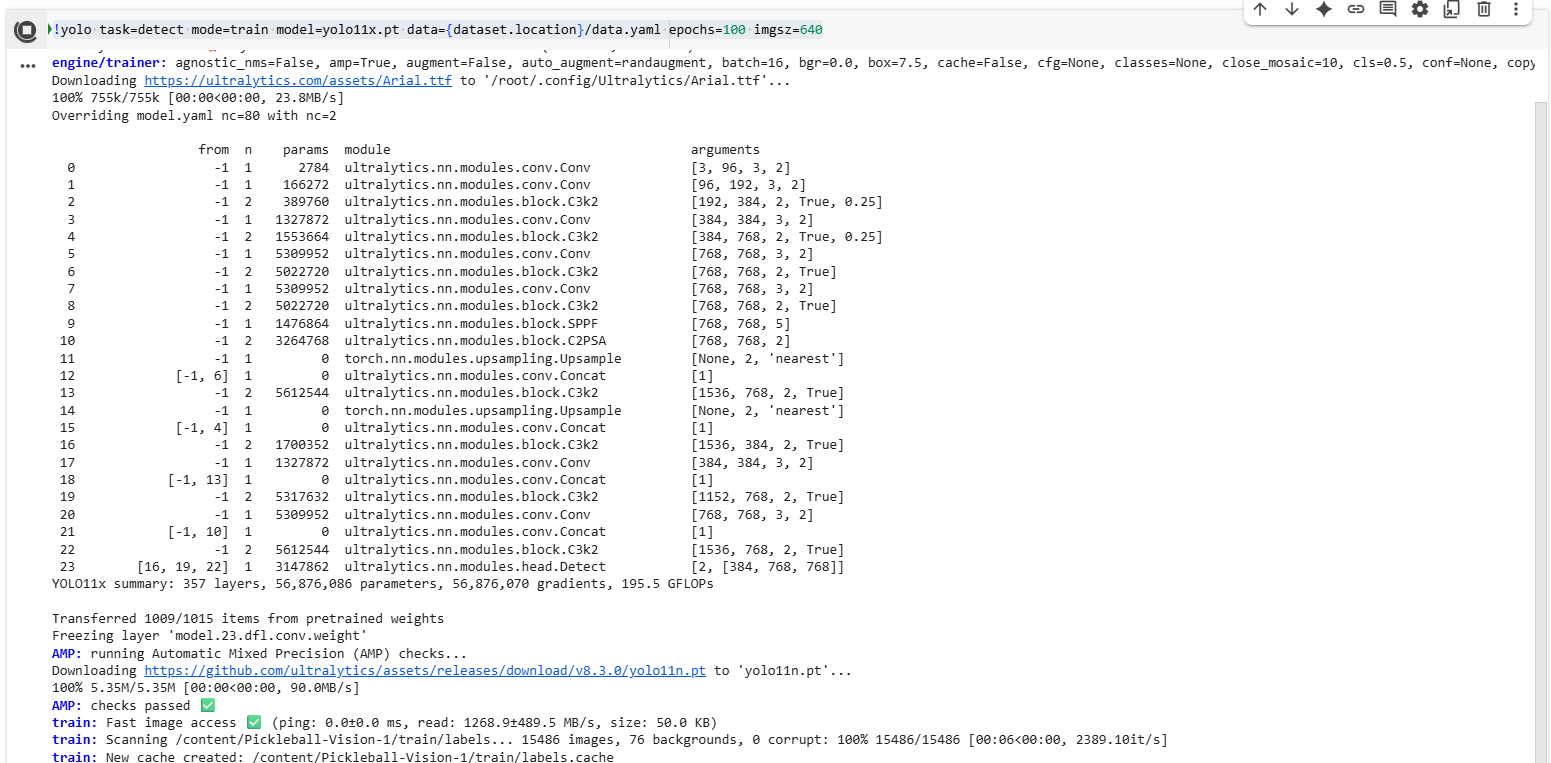

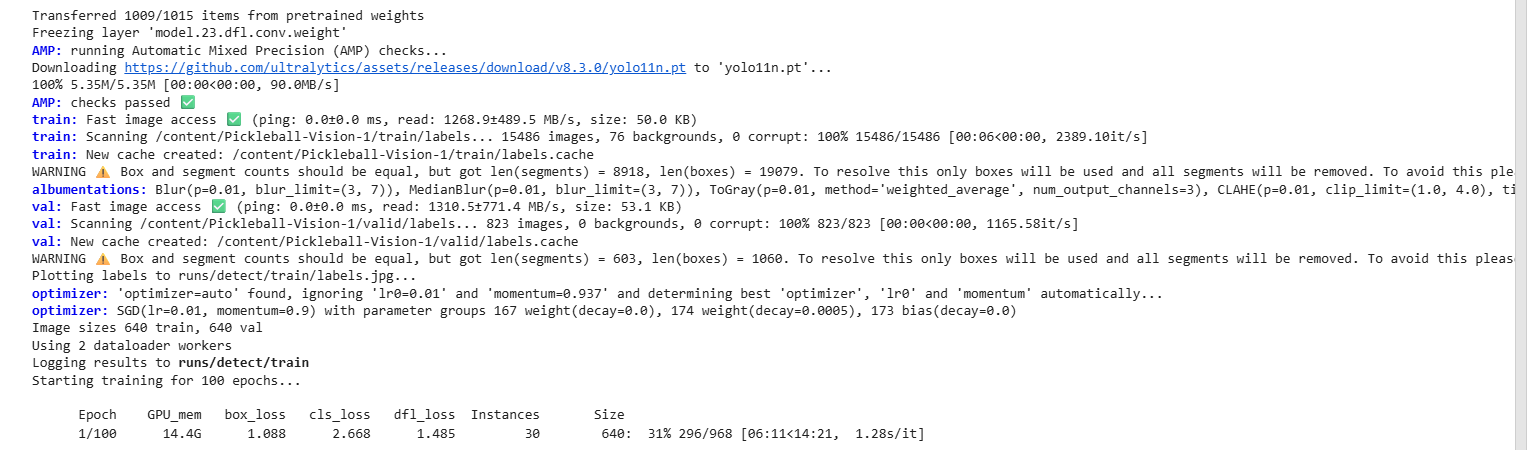

In [ ]:
!yolo task=detect mode=train model=yolo11x.pt data={dataset.location}/data.yaml epochs=100 imgsz=640

## Unable to run on Google Colab due to a lack of compute. Use inference on roboflow server

In [19]:
from inference_sdk import InferenceHTTPClient
import os
from dotenv import load_dotenv

load_dotenv() # Load the .env file
api_key = os.getenv("ROBOFLOW_API_KEY")

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=api_key
)

image_path = '../input_videos/frames_00304_jpg.rf.1bfef6c4799a2e6fbb850802256667b3.jpg'

result = CLIENT.infer(inference_input=image_path, model_id="pickleball-vision/6")
print(result)

{'inference_id': '135cf1f4-41b5-46bc-87b4-31baabfc3c37', 'time': 0.012394138999297866, 'image': {'width': 640, 'height': 640}, 'predictions': [{'x': 390.5, 'y': 106.5, 'width': 7.0, 'height': 13.0, 'confidence': 0.6065341234207153, 'class': 'ball', 'class_id': 0, 'detection_id': '740b6f91-80b3-4762-9cec-27166c35b3d9'}]}


{'inference_id': 'cc8f9784-90ba-4ae6-a7a5-552a2710ef6d', 'time': 0.01196690500000841, 'image': {'width': 640, 'height': 640}, 'predictions': [{'x': 390.5, 'y': 106.5, 'width': 7.0, 'height': 13.0, 'confidence': 0.6065341234207153, 'class': 'ball', 'class_id': 0, 'detection_id': '35b26bcd-4faa-466e-a762-8499d36ba290'}]}


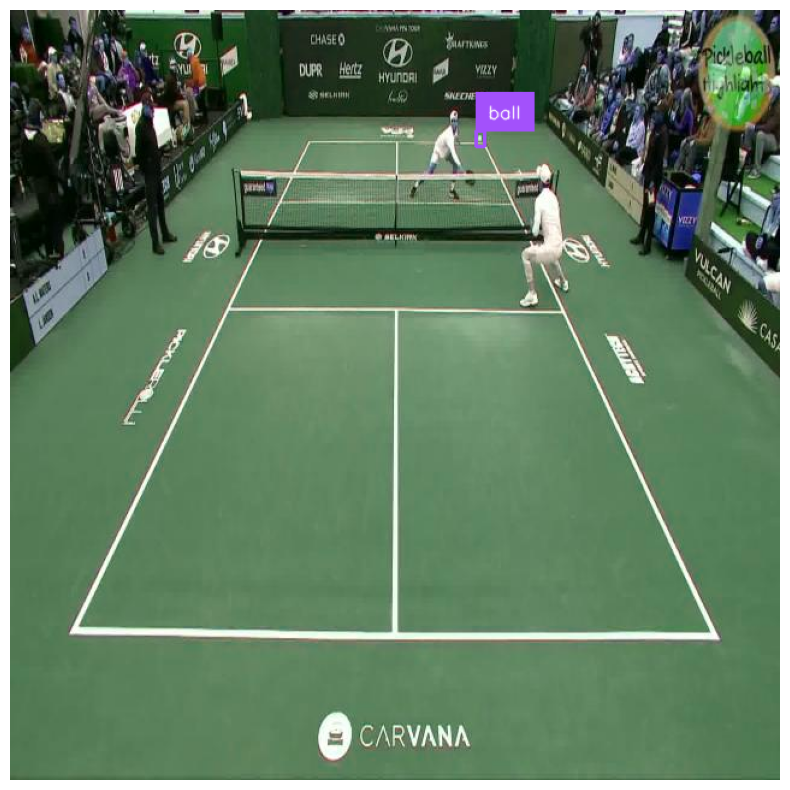

In [20]:
import cv2
import supervision as sv
from inference_sdk import InferenceHTTPClient
import numpy as np

from inference_sdk import InferenceHTTPClient
from dotenv import load_dotenv

# --- 1. Your Roboflow Inference Setup (from your image) ---

load_dotenv() # Load the .env file
api_key = os.getenv("ROBOFLOW_API_KEY")

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=api_key
)

image_path = '../input_videos/frames_00304_jpg.rf.1bfef6c4799a2e6fbb850802256667b3.jpg'

result = CLIENT.infer(inference_input=image_path, model_id="pickleball-vision/6")
print(result)

# # --- 2. Load the original image ---
image = cv2.imread(image_path)

# Check if image was loaded successfully
if image is None:
    print(f"Error: Could not load image from {image_path}")
    exit()

# Convert the image from BGR to RGB (OpenCV loads in BGR, but most display tools expect RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- 3. Process Roboflow result with Supervision ---
# Create a Supervision Detections object from the Roboflow result
detections = sv.Detections.from_inference(result)

# Optionally filter detections based on confidence if needed
detections = detections[detections.confidence > 0.5]

# Get the class names from the result
class_names = [p["class"] for p in result["predictions"]]

# --- 4. Annotate the image with bounding boxes and labels ---
# Create annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Annotate the image
annotated_image = bounding_box_annotator.annotate(
    scene=image.copy(), # Make a copy to avoid modifying the original image
    detections=detections
)

# Add labels
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=class_names # Pass the extracted class names for display
)

# --- 5. Display the annotated image ---
sv.plot_image(annotated_image, size=(10, 10))